In [21]:
import shutil, os
import posixpath
import pandas as pd
import swifter
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

data_dir = 'data/data_merged'

## Functions

In [8]:
def merge_data():
    dirlist = os.listdir('data/dev-clean')
    for dir1 in dirlist:
        files = []
        person_dir = f'data/dev-clean/{dir1}'
        person_dirs = os.listdir(person_dir)
        for dir2 in person_dirs:
            filenames = os.listdir(posixpath.join(person_dir, dir2))
            files += [posixpath.join(person_dir, dir2, filename) for filename in filenames]

        print(files)
        for f in files:
            shutil.copy(f, data_dir)

def extract_features(files):
    file_name = os.path.join(os.path.abspath(data_dir)+'/'+str(files.file))
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))
    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)

    return mfccs, chroma, mel, contrast, tonnetz


In [9]:
filelist = os.listdir(data_dir)
train_df = pd.DataFrame(filelist)

train_df = train_df.rename(columns={0:'file'})
train_df['file'] = train_df[train_df['file'].str.split('.', expand=True)[1]=='flac']
train_df.dropna(inplace=True)
train_df['speaker'] = train_df['file'].apply(lambda x: x.split('-')[0])
train_df.reset_index(inplace=True, drop=True)
train_df.head(5)

,file,speaker
0,1272-128104-0000.flac,1272
1,1272-128104-0001.flac,1272
2,1272-128104-0002.flac,1272
3,1272-128104-0003.flac,1272
4,1272-128104-0004.flac,1272


### Cut Data to 10 voices, 35 samples

In [10]:
train_df = train_df[train_df['speaker'].isin(train_df['speaker'].unique()[:10])] #take first 10 voices
train_df = train_df.groupby(['speaker']).apply(lambda grp: grp.sample(n=35)).reset_index(drop=True)
train_df

,file,speaker
0,1272-135031-0008.flac,1272
1,1272-141231-0027.flac,1272
2,1272-141231-0000.flac,1272
3,1272-141231-0018.flac,1272
4,1272-135031-0005.flac,1272
...,...,...
345,2086-149220-0022.flac,2086
346,2086-149220-0032.flac,2086
347,2086-149214-0004.flac,2086
348,2086-149220-0031.flac,2086


In [11]:
train_df.value_counts(['speaker'])

speaker
1272       35
1462       35
1673       35
174        35
1919       35
1988       35
1993       35
2035       35
2078       35
2086       35
dtype: int64

### Get features

In [12]:
train_features = train_df.apply(extract_features, axis=1)
features_train = []
for i in range(0, len(train_features)):
    features_train.append(np.concatenate((
        train_features[i][0],
        train_features[i][1], 
        train_features[i][2], 
        train_features[i][3],
        train_features[i][4]), axis=0))



F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=929
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=600
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=786
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=843
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=800
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=927
  n_fft, y.shape[-1]
F:\Anaconda\envs\tf_gpu3\lib

### Split and transform data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(features_train, train_df['speaker'], test_size=0.2, shuffle=True)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, shuffle=True) # 0.25 x 0.8 = 0.2

test_df = pd.DataFrame({'speaker': y_test}).reset_index(drop=True)

lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_val = to_categorical(lb.fit_transform(y_val))

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

### Training

Train on 224 samples, validate on 56 samples
Epoch 1/100
224/224 [==============================] - 1s 4ms/sample - loss: 2.7958 - accuracy: 0.0580 - val_loss: 2.2637 - val_accuracy: 0.2143
Epoch 2/100
224/224 [==============================] - 0s 67us/sample - loss: 2.4436 - accuracy: 0.1295 - val_loss: 2.1100 - val_accuracy: 0.4107
Epoch 3/100
224/224 [==============================] - 0s 45us/sample - loss: 2.1989 - accuracy: 0.1920 - val_loss: 1.9742 - val_accuracy: 0.5536
Epoch 4/100
224/224 [==============================] - 0s 40us/sample - loss: 2.0740 - accuracy: 0.2812 - val_loss: 1.8499 - val_accuracy: 0.5714
Epoch 5/100
224/224 [==============================] - 0s 45us/sample - loss: 1.8903 - accuracy: 0.3661 - val_loss: 1.7306 - val_accuracy: 0.7143
Epoch 6/100
224/224 [==============================] - 0s 45us/sample - loss: 1.7821 - accuracy: 0.3795 - val_loss: 1.6137 - val_accuracy: 0.7500
Epoch 7/100
224/224 [==============================] - 0s 54us/sample - loss: 1.

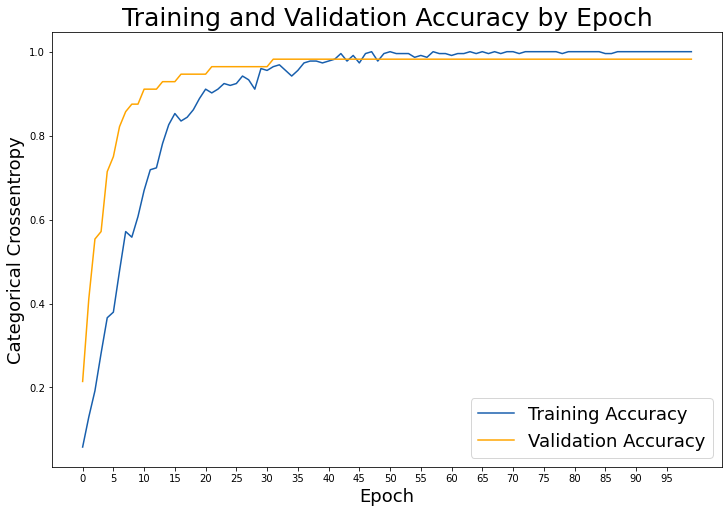

In [23]:
# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 10 classes
model = Sequential()
model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Set figure size.
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);

### Predictions

In [41]:
# We get our predictions from the test data
predictions = model.predict_classes(X_test)
# We transform back our predictions to the speakers ids
predictions = lb.inverse_transform(predictions)
# Finally, we can add those predictions to our original dataframe
test_df['predictions'] = predictions

test_df.head()

,speaker,predictions
0,2086,2086
1,1993,1993
2,1462,1462
3,2086,2086
4,2035,2035


In [42]:
# Code to see which values we got wrong
test_df[test_df['speaker'] != test_df['predictions']]
# Code to see the numerical accuracy
(1-round(len(test_df[test_df['speaker'] != test_df['predictions']])/len(test_df),3))*100

100.0